In [1]:
from IPython.core.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

30038
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.mix as mix
from matplotlib import ticker
import time
from scipy import special

path_ = "../results/LKW-1D-results/"
colors_ = ['b', 'r', 'g', 'gray', 'orange']

# cmap = 'seismic'
# cmap = 'bwr'
# cmap = 'jet'
# cmap = 'coolwarm'
cmap_one_sign_ = 'YlGn'
cmap_two_signs_= 'coolwarm'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

# ---------------------------------------------------
# --- For reading results ---
# ---------------------------------------------------
def read_results(fname_loc):
    dd = {}
    fname = path_ + "/" + fname_loc
    dd["fname"] = fname
    
    print(f"Reading the file {fname}...")
    with h5py.File(fname, "r") as f:
        # ---
        bg           = f["basic"]
        date_sim    = bg["date-of-simulation"][()].decode("utf-8")
        # ---
        bg = f["parameters"]
        w = bg["w"][()]
        vw = bg["vw"][()]
        xs  = bg["source_x0"][()]
        dxs = bg["source_dx"][()] 
        # ---
        bg = f["grids"]
        x = np.array(bg["x"])
        Nx = len(x)
        # ---
        bg = f["profiles"]
        b_temp = np.array(bg["b"])
        # ---
        bg = f["result"]
        psi = np.array(bg["psi"])
        
    print("date of the simulation: ", date_sim)
    print("Nx: {:d}".format(Nx))
    
    b = np.zeros(len(b_temp), dtype=np.complex)
    for ii in range(len(b_temp)):
        temp_v1 = b_temp[ii]
        b[ii] = np.complex(temp_v1[0], temp_v1[1])

    dd["g"] = np.zeros(Nx, dtype=np.complex)
    for ix in range(Nx):
        vg = psi[ix]
        dd["g"][ix] = np.complex(vg[0], vg[1])
        
        
    # analytical solution:
    v, wg, x0 = vw, dxs, xs
    q0 = 1./(np.sqrt(2*np.pi) * wg)
    kx = w/vw
    
    xx20   = -w*(w*wg**2 + 2j*v*x0)/(2*v**2)
    xx40   = (w*wg**2 + 1j*v*x0)**2/(2*v**2*wg**2)
    xx40_2 = (w*wg**2 + 1j*v*x0)/(np.sqrt(2)*v*wg)
    
    cc1 = (q0/(2*v*w)) * 1j*np.exp(xx20) * (2*v*np.exp(xx40) - np.sqrt(2*np.pi)*w*wg*special.erfi(xx40_2))
    ua_1 = np.exp(1j*kx*x) * cc1
    
    xx3 = (w*wg**2 - 1j*v*(x-x0))/(np.sqrt(2)*v*wg)
    ua_2 = (np.sqrt(np.pi/2)*q0*wg/v) * 1j*np.exp(1j*kx*x + xx20) * special.erfi(xx3)
    
    ua = - ua_1 - ua_2
    
    # analytical the rest of the data:        
    dd.update({
        "x": x,
        "Nx": Nx, 
        "nx": int(np.log2(Nx)), 
        "w": w, 
        "vw": vw, 
        "b": b,
        "ua": ua,
        "source-x0": xs, 
        "source-dx": dxs
    })
    return dd


# -----------------------------------------------------------------
# --- For plotting ---
# -----------------------------------------------------------------
def compare_results(dds):
    N_sims = len(dds)
    
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.real(dd["g"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx, w, vw = {:d}, {:0.3f}, {:0.3f}".format(dd["nx"], dd["w"], dd["vw"])
        )
        del dd
    ax.plot(
        dds[0]["x"], np.real(dds[0]["ua"]), 
        color="black", linewidth = 2, linestyle='--', label="analytical"
    )
    plt.xlabel('$x$')
    plt.ylabel("Re[g]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.imag(dd["g"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx, w, vw = {:d}, {:0.3f}, {:0.3f}".format(dd["nx"], dd["w"], dd["vw"])
        )
        del dd
    ax.plot(
        dds[0]["x"], np.imag(dds[0]["ua"]), 
        color="black", linewidth = 2, linestyle='--', label="analytical"
    )
    plt.xlabel('$x$')
    plt.ylabel("Im[g]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig1, fig2


def plot_source(dds):
    N_sims = len(dds)
    
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.real(dd["b"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx, w, vw = {:d}, {:0.3f}, {:0.3f}".format(dd["nx"], dd["w"], dd["vw"])
        )
        del dd
    plt.xlabel('$x$')
    plt.ylabel("Re[RHS vector]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"], np.imag(dd["b"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx, w, vw = {:d}, {:0.3f}, {:0.3f}".format(dd["nx"], dd["w"], dd["vw"])
        )
        del dd
    plt.xlabel('$x$')
    plt.ylabel("Im[RHS vector]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig1, fig2

In [36]:
# ---------------------------------------------------
# --- Read results ---
# ---------------------------------------------------
# dd_8 = read_results("wavesim_8_outgoing.hdf5")
# dd_9 = read_results("wavesim_9_outgoing.hdf5")
dd_10 = read_results("wavesim_10_outgoing.hdf5")

# dd_8 = read_results("wavesim_8_dirichlet.hdf5")
# dd_9 = read_results("wavesim_9_dirichlet.hdf5")
# dd_10 = read_results("wavesim_10_dirichlet.hdf5")

# dd_8 = read_results("wavesim_8_free.hdf5")
# dd_9 = read_results("wavesim_9_free.hdf5")
# dd_10 = read_results("wavesim_10_free.hdf5")

Reading the file ../results/LKW-1D-results//wavesim_10_outgoing.hdf5...
date of the simulation:  04-12-2023 15:30:00
Nx: 1024


<IPython.core.display.Javascript object>


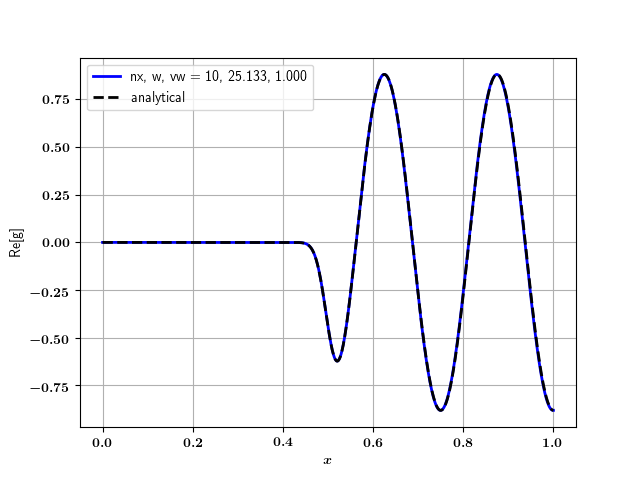

<IPython.core.display.Javascript object>


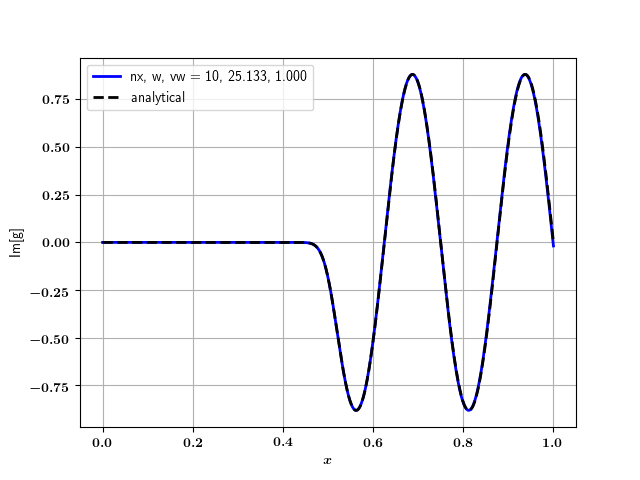

In [37]:
# ---------------------------------------------------
# --- Results ---
# ---------------------------------------------------
fig_nv_re, fig_nv_im = compare_results([dd_10])
# fig_nv_re, fig_nv_im = compare_results([dd_8, dd_9, dd_10])

# fig_nv_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/temp/' + "/Er-nv.eps")

In [30]:
# ---------------------------------------------------
# --- RHS vector ---
# ---------------------------------------------------
plot_source([dd])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)